# MathematicalProgram 调试技巧
有关如何运行这些教程笔记本的说明，请参见 [index](./index.ipynb)。


## 重要提示
有关如何在 Drake 中构建和求解一般优化问题，请参阅 [mathematical program tutorial](./mathematical_program.ipynb)。

在通过 Drake 的 `MathematicalProgram` 接口构建并求解优化问题后，你可能得不到期望的结果。例如，你可能认为问题有解，但 `MathematicalProgram` 却报告问题未能成功求解。本教程将提供一些调试 `MathematicalProgram` 的技巧，以便在其表现不如预期时进行排查。

首先你需要了解你的优化问题是否为凸问题。对于凸问题（如 LP、QP、SDP），只要问题可行，理论上求解器总能找到解；而对于非凸问题，若使用基于梯度的求解器（如 SNOPT/IPOPT），即使存在可行解，求解器也可能无法终止于可行解。当基于梯度的求解器（如 SNOPT/IPOPT）报告问题不可行时，这仅意味着求解器在某个不可行点陷入困境，并且在该点的局部邻域内无法降低不可行性。可能在远离该点的地方存在可行解，但求解器被困住，无法跳跃到远处的解。此时可以尝试更换优化问题的初始猜测。

下面通过一个例子展示初始猜测在非线性优化中的重要性。

从 x=[0, 0] 出发，求解器结果为 SolutionResult.kInfeasibleConstraints
求解器卡在 x=[0. 0.]
从 x=[0.1, 0.5] 出发，求解器结果为 SolutionResult.kSolutionFound
找到的解为 x=[0.01022453 1.08219118]


/tmp/ipykernel_189552/1980250842.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


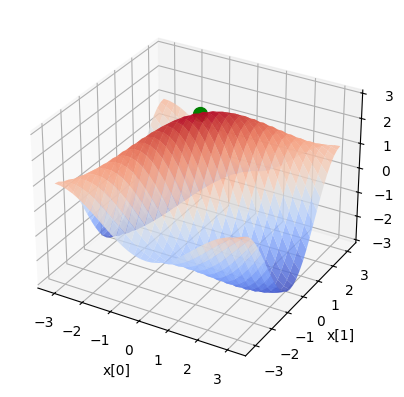

In [13]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pydrake.solvers import MathematicalProgram
from pydrake.solvers import IpoptSolver
import numpy as np


def constraint(x):
    return [np.cos(x[0]) + 2 * np.cos(x[0] - x[1])]

# 寻找满足以下条件的解：
# 1 <= cos(x[0]) + 2 * cos(x[0] - x[1]) <= 2
# 该问题有无穷多解，例如 x = [0, pi/2]。

# 为了可视化约束，这里绘制了 cos(x[0]) + 2 * cos(x[0] - x[1]) 的景观，
# 并高亮显示点 x = [0, 0]。可以看到 x = [0, 0] 位于景观的一个峰值。
def draw_constraint_landscape():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x_mesh, y_mesh = np.meshgrid(np.linspace(-np.pi, np.pi, 31), np.linspace(-np.pi, np.pi, 31))
    constraint_val = np.cos(x_mesh) + 2 * np.cos(x_mesh - y_mesh)
    surf = ax.plot_surface(x_mesh, y_mesh, constraint_val, cmap=cm.coolwarm, alpha=0.8)
    ax.plot([0], [0], [3], marker='.', color='g', markersize=20)
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
    ax.set_zlabel("cos(x[0]) + 2 * cos(x[0]-x[1])")
    fig.show()
    

draw_constraint_landscape()

prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "x")

prog.AddConstraint(constraint, [1], [2], x)

solver = IpoptSolver()
# 初始猜测为 (0, 0) 时，求解器无法找到解。
prog.SetInitialGuess(x, [0, 0])
result = solver.Solve(prog)
print(f"从 x=[0, 0] 出发，求解器结果为 {result.get_solution_result()}")
print(f"求解器卡在 x={result.GetSolution(x)}")

# 更换初始猜测后，求解器可以找到解
prog.SetInitialGuess(x, [0.1, 0.5])
result = solver.Solve(prog)
print(f"从 x=[0.1, 0.5] 出发，求解器结果为 {result.get_solution_result()}")
print(f"找到的解为 x={result.GetSolution(x)}")

在上面的例子中可以看到，若初始猜测 $x = [0, 0]$ 不佳，求解器会卡住并报告问题不可行（卡住的原因是约束函数 $cos(x[0]) + 2cos(x[0]-x[1])$ 在初始猜测 $x=[0, 0]$ 处梯度为零，基于梯度的求解器无法移动决策变量。这种现象在逆运动学问题初始位姿处于奇异点，或单位长度约束 $x^Tx=1$ 初始猜测为 $x=0$ 时也会出现）；但更换初始猜测后，求解器可以找到解。

注意即使求解器（如 SNOPT）在优化过程中找到过可行解，也可能在后续迭代跳到不可行点。SNOPT 并不保证优化过程中始终在可行域内。

有时问题不可行是因为约束设置有误。为理解优化失败的原因，下面提供一些调试技巧。你可以用这些方法诊断有问题的约束或初始猜测。

## 打印 MathematicalProgram 摘要
尤其对于小问题，将 MathematicalProgram 以字符串形式显示非常有帮助。这样可以看到程序中添加的决策变量、代价和约束的列表。

In [14]:
# 一个示例（二次）规划问题
prog = MathematicalProgram()
x = prog.NewContinuousVariables(3, "x")
prog.AddQuadraticCost(x[0] * x[0] + 2 * x[0] + 3)
prog.Add2NormSquaredCost(A = [[1, 3], [2, 4]], b=[1, 4], vars=[x[1], x[2]])
prog.AddLinearEqualityConstraint(x[0] + 2*x[1] == 5)
prog.AddLinearConstraint(x[0] + 4 *x[1] <= 10)
prog.AddBoundingBoxConstraint(-1, 10, x)

# 打印摘要：
print(prog)

Decision variables: x(0) x(1) x(2)

QuadraticCost (3 + 2 * x(0) + pow(x(0), 2))
QuadraticCost (17 - 18 * x(1) - 38 * x(2) + (x(1) * (5 * x(1) + 11 * x(2))) + (x(2) * (11 * x(1) + 25 * x(2))))
LinearConstraint
-inf <= (x(0) + 4 * x(1)) <= 10
LinearEqualityConstraint
(x(0) + 2 * x(1)) == 5
BoundingBoxConstraint
-1 <= x(0) <= 10
-1 <= x(1) <= 10
-1 <= x(2) <= 10



你还可以用 LaTeX 形式显示该程序

In [15]:
display(Markdown(prog.ToLatex()))

\begin{align*}
\min_{x_{0}, x_{1}, x_{2}} \quad & (3 + 2x_{0} + x_{0}^{2})\\
 &  + (17 - 18x_{1} - 38x_{2} + x_{1} (5x_{1} + 11x_{2}) + x_{2} (11x_{1} + 25x_{2}))\\
 \text{subject to}\quad & (x_{0} + 4x_{1}) \le 10,\\
 & (x_{0} + 2x_{1}) = 5,\\
 & \begin{bmatrix} -1 \\ -1 \\ -1 \end{bmatrix} \le \begin{bmatrix} x_{0} \\ x_{1} \\ x_{2} \end{bmatrix} \le \begin{bmatrix} 10 \\ 10 \\ 10 \end{bmatrix}.\\
\end{align*}


## 为代价/约束/变量命名
打印部分约束/代价有助于诊断问题。为了获得有意义的输出信息，可以为代价/约束/变量命名。
### 1. 命名变量
通过 `NewContinuousVariables`（或 `NewBinaryVariables`）创建变量时，可以传入字符串作为变量名。例如：

In [16]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
print(x)

[Variable('point(0)', Continuous) Variable('point(1)', Continuous)]


### 2. 命名约束
可以用 `set_description()` 方法为约束命名。例如：

In [17]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
constraint = prog.AddConstraint(lambda z: [np.sum(z**2)], [1.], [1.], x)
constraint.evaluator().set_description("单位长度约束")
print(constraint)

PyFunctionConstraint described as '单位长度约束' with 2 decision variables point(0) point(1)



### 3. 命名代价
同样可以用 `set_description()` 方法为代价命名。例如：

In [18]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
# 添加到 (1, 2) 的距离代价
cost1 = prog.AddCost(lambda z: np.sqrt((z[0]-1)**2 + (z[1]-2)**2), x)
cost1.evaluator().set_description("到 (1, 2) 的距离")
# 添加到 (3, -1) 的距离代价
cost2 = prog.AddCost(lambda z: np.sqrt((z[0]-3)**2 + (z[1] + 1)**2), x)
cost2.evaluator().set_description("到 (3, -1) 的距离")
print(f"cost1: {cost1}")
print(f"cost2: {cost2}")

cost1: PyFunctionCost described as '到 (1, 2) 的距离' with 2 decision variables point(0) point(1)

cost2: PyFunctionCost described as '到 (3, -1) 的距离' with 2 decision variables point(0) point(1)



如下一节所示，我们可以打印出不可行的约束。通过为变量/约束/代价命名，输出信息会更有意义。

## 调用 GetInfeasibleConstraints()
当用基于梯度的求解器（如 SNOPT/IPOPT）求解 `MathematicalProgram` 并报告问题不可行时，求解器会返回其卡住时的决策变量值。你可以调用 [MathematicalProgramResult::GetInfeasibleConstraints()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.MathematicalProgramResult.GetInfeasibleConstraints) 或 [MathematicalProgramResult::GetInfeasibleConstraintNames()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.MathematicalProgramResult.GetInfeasibleConstraintNames) 获取在该变量值下违反最严重的约束。你可以据此诊断不可行的约束并改进约束或初始猜测。

例如：

In [19]:
import numpy as np
from pydrake.autodiffutils import (
    InitializeAutoDiff,
    ExtractGradient,
    )
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "x")

# 添加约束 dist(x, 0) >= 1
constraint1 = prog.AddConstraint(lambda z: [z.dot(z)], [1], [np.inf], x)
constraint1.evaluator().set_description("在单位圆外")

# 添加约束 x[0]**2 + 4 * x[1]**2 <= 4
constraint2 = prog.AddConstraint(lambda z: [z[0]**2 + 4 * z[1]**2], [0], [4], x)
constraint2.evaluator().set_description("在椭球体1内")

solver = IpoptSolver()
prog.SetInitialGuess(x, [0, 0])
result = solver.Solve(prog)
print("初始猜测 x = [0, 0]")
print(f"优化状态: {result.get_solution_result()}")
infeasible_constraints = result.GetInfeasibleConstraints(prog)
for c in infeasible_constraints:
    print(f"不可行约束: {c}")
x_stuck = result.GetSolution(x)
print(f"x_stuck={x_stuck.T}")
# 现在在卡住点 x_stuck 处计算约束的梯度
print(f"不可行约束在 x_stuck 处的梯度: {ExtractGradient(infeasible_constraints[0].evaluator().Eval(InitializeAutoDiff(x_stuck)))}")

# 换一个初始状态，不可行约束的梯度现在非零
x_new = np.array([0.1, 0.2])
print(f"\n初始猜测 x_new = {x_new}")
print(f"不可行约束在 x_new 处的梯度: {ExtractGradient(infeasible_constraints[0].evaluator().Eval(InitializeAutoDiff(x_new)))}")
prog.SetInitialGuess(x, x_new)
# 用新初始猜测，求解器可以找到解
result = solver.Solve(prog)
print(f"优化状态: {result.get_solution_result()}")

初始猜测 x = [0, 0]
优化状态: SolutionResult.kInfeasibleConstraints
不可行约束: PyFunctionConstraint described as '在单位圆外' with 2 decision variables x(0) x(1)

x_stuck=[0. 0.]
不可行约束在 x_stuck 处的梯度: [[0. 0.]]

初始猜测 x_new = [0.1 0.2]
不可行约束在 x_new 处的梯度: [[0.2 0.4]]
优化状态: SolutionResult.kSolutionFound


## 启用求解器详细输出
许多求解器可以在每次迭代时打印进度。要启用输出，可以设置 [kPrintToConsole](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.CommonSolverOption) 或 [kPrintFileName](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.CommonSolverOption) 选项，详见 [SolverOptions](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.SolverOptions)。

注意：在 Jupyter notebook 中运行代码时，求解器的输出会打印到启动 notebook 的控制台，而不是 notebook 窗口。如果是在在线 notebook（如 Deepnote）中，控制台输出不可见，此时建议输出到文件。

In [20]:
from pydrake.solvers import CommonSolverOption, SolverOptions

# 创建一个简单的程序，包括：
# 约束：1 <= squared_norm(x) <= 2。
# 约束：2 <= x[0]**2 + 4 * x[0]*x[1] + 4*x[1]**2 + 2 * x[0] <= 5。
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(lambda z: [z.dot(z)], [1], [2], x)
prog.AddConstraint(lambda z: [z[0] ** 2 + 4 * z[0] * z[1] + 4 * z[1]**2 + 2 * z[0]], [2], [5], x)
prog.SetInitialGuess(x, [0, 0])

# 启用输出进行求解。
ipopt_solver = IpoptSolver()
filename = "/tmp/debug.txt"
solver_options = SolverOptions()
solver_options.SetOption(CommonSolverOption.kPrintFileName, filename)
result = ipopt_solver.Solve(prog, solver_options=solver_options)
with open(filename) as f:
    print(f.read())


Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   3.7006228269566876e-11    3.7006228269566876e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

部分求解器支持更细致的进度输出调节。例如 [IPOPT 选项](https://coin-or.github.io/Ipopt/OPTIONS.html) 提供了 IPOPT 专用的 `print_level`（控制台输出）和 `file_print_level`（文件输出）。

In [21]:
# 这次启用更详细的输出。
# 这些选项可以直接附加到程序上，而不必在 Solve() 时传递。
solver_options.SetOption(IpoptSolver.id(), "print_level", 5)
prog.SetSolverOptions(solver_options)
result = ipopt_solver.Solve(prog)

This is Ipopt version drake_vendor, running with linear solver spral.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

## 添加回调函数
部分求解器支持添加回调函数，在优化过程中每次迭代都会执行。你可以用回调函数可视化优化进展。

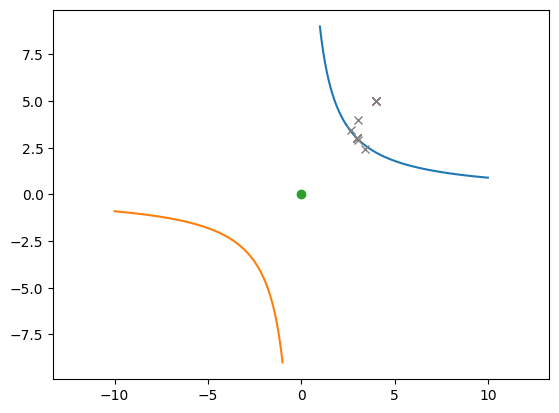

In [22]:
# 通过回调函数可视化求解器每次迭代的进展
# 寻找曲线上距离目标点最近的点。
from pydrake.solvers import Solve

fig = plt.figure()
curve_x = np.linspace(1, 10, 100)
ax = plt.gca()
ax.plot(curve_x, 9./curve_x)
ax.plot(-curve_x, -9./curve_x)
ax.plot(0, 0, 'o')
x_init = [4., 5.]
ax.plot(x_init[0], x_init[1], 'x')
ax.axis('equal')

def visualization_callback(x):
    ax.plot(x[0], x[1], 'x', color='gray')
    
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] * x[1] == 9)
prog.AddCost(x[0]**2 + x[1]**2)
prog.AddVisualizationCallback(visualization_callback, x)
result = Solve(prog, x_init)

## 使用 EvalBinding
对于每个单独的约束/代价，可以调用 [EvalBinding(binding, x)](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.MathematicalProgram.EvalBinding) 在决策变量取值为 `x` 时评估该约束/代价。


In [23]:
## 演示 EvalBinding 函数
prog = MathematicalProgram()
p1 = prog.NewContinuousVariables(2, "p1")
p2 = prog.NewContinuousVariables(2, "p2")

# 添加约束：p1 在椭球体 (p1(0)-1)**2 + 4*(p1(1)-2)**2 <= 1 内
constraint1 = prog.AddConstraint(lambda z: [(z[0]-1)**2 + 4 * (z[1]-2)**2], [0], [1], p1)
# 添加约束：p2 在椭球体 (p2(0) + 2)**2 + 0.25*(p2(1)+ 1)**2) <= 1 内
constraint2 = prog.AddConstraint(lambda z: [(z[0]+2)**2 + 0.25*(z[1]+1)**2], [0], [1], p2)
# 添加代价：最小化 p1 和 p2 之间的距离
cost = prog.AddCost((p1-p2).dot(p1-p2))

# 在猜测 p1=[0, 1], p2 = [-1, -4] 处评估约束和代价
p1_val = [0, 1]
p2_val = [-1, -4]
prog.SetInitialGuess(p1, p1_val)
prog.SetInitialGuess(p2, p2_val)
print(f"约束1在 p1={p1_val}, p2={p2_val} 处的值为 {prog.EvalBinding(constraint1, prog.initial_guess())}")
print(f"约束2在 p1={p1_val}, p2={p2_val} 处的值为 {prog.EvalBinding(constraint2, prog.initial_guess())}")
print(f"代价在 p1={p1_val}, p2={p2_val} 处的值为 {prog.EvalBinding(cost, prog.initial_guess())}")


约束1在 p1=[0, 1], p2=[-1, -4] 处的值为 [5.]
约束2在 p1=[0, 1], p2=[-1, -4] 处的值为 [3.25]
代价在 p1=[0, 1], p2=[-1, -4] 处的值为 [26.]


## 移除/放宽约束
当求解器报告问题不可行时，可以移除或放宽不可行约束，然后重新求解。移除约束很简单，只需注释掉添加该约束的代码行即可。要放宽约束边界，可以用 [UpdateLowerBound()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.PyFunctionConstraint.UpdateLowerBound) 或 [UpdateUpperBound()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.PyFunctionConstraint.UpdateUpperBound) 方法。示例：

In [24]:
# 放宽约束
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)

# 添加约束 x^T * x <= 1
constraint1 = prog.AddConstraint(lambda z: [z.dot(z)], [0], [1], x)
constraint1.evaluator().set_description("在单位圆内")

# 添加约束 norm(x-[3, 0]) <= 1
constraint2 = prog.AddConstraint(lambda z: [np.sum((z - np.array([3, 0]))**2)], [0], [1], x)
constraint2.evaluator().set_description("到 [3, 0] 的距离小于1")

prog.SetInitialGuess(x, [1, 0])
solver = IpoptSolver()
result = solver.Solve(prog)
print(f"原问题求解器状态: {result.get_solution_result()}")
print(f"x 卡在 {result.GetSolution(x)}")
# 获取不可行约束
infeasible_constraints = result.GetInfeasibleConstraints(prog)
for c in infeasible_constraints:
    print(f"不可行约束: {c}")

# 放宽第一个不可行约束的上界
infeasible_constraints[0].evaluator().UpdateUpperBound([4])
# 也可以更新约束描述。若不更新描述，问题依然可解，但打印信息会令人困惑。
infeasible_constraints[0].evaluator().set_description("半径=2 的圆内")
result = solver.Solve(prog)
print(f"放宽后问题求解器状态: {result.get_solution_result()}")
print(f"解为 x = {result.GetSolution(x)}")

原问题求解器状态: SolutionResult.kInfeasibleConstraints
x 卡在 [1.5 0. ]
不可行约束: PyFunctionConstraint described as '在单位圆内' with 2 decision variables x(0) x(1)

不可行约束: PyFunctionConstraint described as '到 [3, 0] 的距离小于1' with 2 decision variables x(0) x(1)

放宽后问题求解器状态: SolutionResult.kSolutionFound
解为 x = [2. 0.]
